# LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns
import os
import math

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Activation, Input, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences

from PIL import Image

***

**Utility Functions**

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [4]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [5]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [6]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth = 2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth = 2, color = colors[6], linestyle = ':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**Prepare datasets**

In [7]:
train_features = np.load('train_dataset_features.npy', allow_pickle=True)
train_labels = np.load('train_dataset_labels.npy', allow_pickle=True)

In [8]:
test_features = np.load('test_dataset_features.npy', allow_pickle=True)
test_labels = np.load('test_dataset_labels.npy', allow_pickle=True)

In [9]:
val_features = np.load('val_dataset_features.npy', allow_pickle=True)
val_labels = np.load('val_dataset_labels.npy', allow_pickle=True)

**Define the model and metrics**



In [10]:
KERAS_METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'), 
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'auc'),
]

In [11]:
MAX_FEATURES = 25000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(train_features))
tokenized_train = tokenizer.texts_to_sequences(train_features)
tokenized_test = tokenizer.texts_to_sequences(test_features)
tokenized_val = tokenizer.texts_to_sequences(val_features)

In [12]:
tokenizer.word_counts

OrderedDict([('two', 32663),
             ('liberals', 1535),
             ('crusade', 192),
             ('submit', 1132),
             ('petition', 925),
             ('oregon', 1139),
             ('secede', 101),
             ('union', 6323),
             ('new', 53446),
             ('hop', 4573),
             ('make', 60283),
             ('safe', 3321),
             ('space', 3044),
             ('bigoted', 384),
             ('plan', 20614),
             ('states', 26130),
             ('succession', 181),
             ('by', 7110),
             ('shepard', 124),
             ('ambellas', 16),
             ('november', 7561),
             ('portland', 370),
             ('intellihub', 30),
             ('name', 12148),
             ('jennifer', 497),
             ('rollins', 38),
             ('christian', 2783),
             ('trejbal', 4),
             ('likely', 9767),
             ('offend', 793),
             ('powerhouse', 138),
             ('personality', 622),
        

In [13]:
tokenizer.word_index

{'say': 1,
 'the': 2,
 'trump': 3,
 'would': 4,
 'us': 5,
 'people': 6,
 'one': 7,
 'it': 8,
 'president': 9,
 'make': 10,
 'state': 11,
 'go': 12,
 'mr': 13,
 'new': 14,
 'also': 15,
 'in': 16,
 'take': 17,
 'get': 18,
 'clinton': 19,
 'time': 20,
 'like': 21,
 'he': 22,
 'but': 23,
 'tell': 24,
 'could': 25,
 'know': 26,
 'come': 27,
 'this': 28,
 'government': 29,
 'house': 30,
 'call': 31,
 'even': 32,
 'use': 33,
 'campaign': 34,
 'work': 35,
 'two': 36,
 'and': 37,
 'we': 38,
 'think': 39,
 'last': 40,
 'obama': 41,
 'first': 42,
 'united': 43,
 'see': 44,
 'many': 45,
 'years': 46,
 'report': 47,
 'vote': 48,
 'donald': 49,
 'want': 50,
 'news': 51,
 'party': 52,
 'include': 53,
 'white': 54,
 'right': 55,
 'republican': 56,
 'show': 57,
 'that': 58,
 'election': 59,
 'year': 60,
 'back': 61,
 'group': 62,
 'give': 63,
 'states': 64,
 'hillary': 65,
 'american': 66,
 'may': 67,
 'support': 68,
 'need': 69,
 'its': 70,
 'country': 71,
 'world': 72,
 'political': 73,
 'former': 74

In [14]:
tokenized_train[:1]

[[36,
  1933,
  7727,
  2457,
  2809,
  2441,
  11382,
  514,
  14,
  2809,
  751,
  10,
  2441,
  1022,
  1122,
  5065,
  1933,
  87,
  64,
  8023,
  460,
  10054,
  420,
  5190,
  22124,
  36,
  1933,
  205,
  4301,
  19567,
  1206,
  306,
  3122,
  9431,
  3670,
  14,
  1566,
  600,
  2809,
  11,
  2441,
  11382,
  514,
  2,
  2809,
  1187,
  2410,
  496,
  6211,
  155,
  745,
  36,
  1373,
  10,
  11,
  790,
  4787,
  6939,
  16037,
  829,
  17406,
  341,
  24,
  16814,
  255,
  16814,
  771,
  791,
  771,
  140,
  880,
  43,
  64,
  1156,
  771,
  259,
  2260,
  4549,
  7201,
  179,
  2141,
  36,
  5065,
  1933,
  306,
  10820,
  219,
  336,
  164,
  97,
  4282,
  1146,
  925,
  79,
  21,
  1810,
  4804,
  720,
  31,
  7201,
  5644,
  10161,
  7225,
  1,
  162,
  23002,
  281,
  824,
  7225,
  36,
  10821,
  956,
  2960,
  707,
  2813,
  50,
  351,
  21,
  3,
  707,
  423,
  2,
  4842,
  9958,
  87,
  18,
  6211,
  69,
  125,
  255,
  10054,
  1118,
  1715,
  5881,
  1031,
  128,


In [16]:
MAX_LEN = 200
x_train = pad_sequences(tokenized_train, maxlen=MAX_LEN)
x_test = pad_sequences(tokenized_test, maxlen=MAX_LEN)
x_val = pad_sequences(tokenized_val, maxlen=MAX_LEN)

In [35]:
y_train = train_labels
y_test = test_labels
y_val = val_labels

In [17]:
totalNumWords = [len(one_comment) for one_comment in tokenized_train]

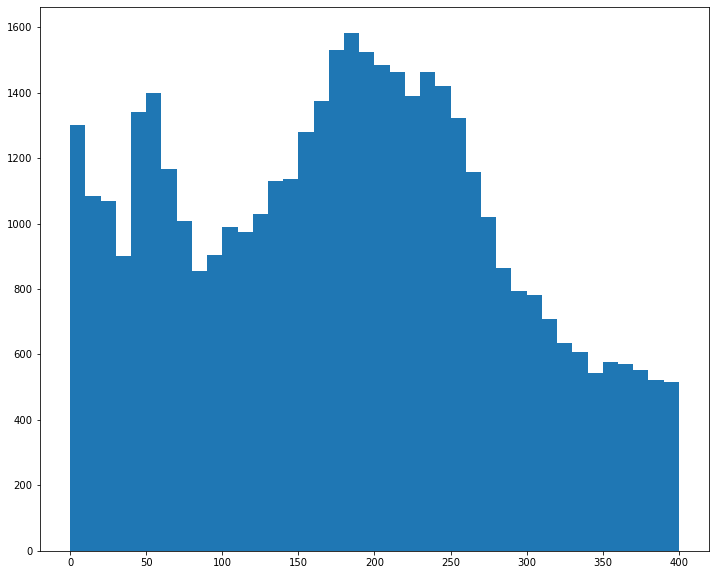

In [18]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [54]:
def make_model():
    
    model = Sequential()
    model.add(Input(shape=(MAX_LEN, )))
    model.add(Embedding(MAX_FEATURES, EMB_SIZE))

    model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
    model.add(GlobalMaxPool1D())
        
    model.add(Dropout(0.1))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.1))
    
    # Finally, we feed the output into a Sigmoid layer, because we are trying to achieve a binary classification(1,0)
    # For each label, and the sigmoid function will squash the output between the bounds of 0 and 1.
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [KERAS_METRICS])
    model.summary()
    return model

In [62]:
model = make_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          5000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           62640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               7808      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1

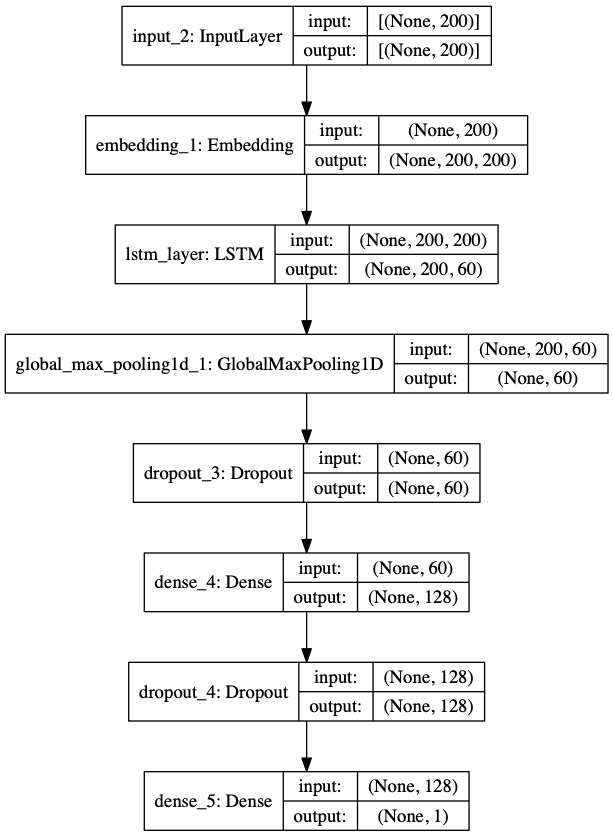

In [63]:
plot_model(model, to_file = 'model_lstm.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_lstm.png')
im

In [64]:
# The exact amount of patience will vary between models and problems and is difficult to calculate exactly. 
# I've seen recommendations as a rule of thumb to use 10% of the number of epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', 
    verbose = 2,
    patience = 10,
    mode = 'max',
    restore_best_weights = True)

In [65]:
callbacks = [early_stopping]

In [66]:
BATCH_SIZE = 64
EPOCHS = 100

In [67]:
history = model.fit(x_train, 
                        y_train, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val, y_val))

Epoch 1/100
855/855 [==============================] - 296s 342ms/step - loss: 0.3270 - tp: 17214.3084 - fp: 1992.5479 - tn: 15610.0643 - fn: 1246.9720 - accuracy: 0.9079 - precision: 0.8898 - recall: 0.9372 - auc: 0.9747 - val_loss: 0.1519 - val_tp: 6652.0000 - val_fp: 409.0000 - val_tn: 6268.0000 - val_fn: 348.0000 - val_accuracy: 0.9447 - val_precision: 0.9421 - val_recall: 0.9503 - val_auc: 0.9850
Epoch 2/100
855/855 [==============================] - 268s 313ms/step - loss: 0.0837 - tp: 13626.0689 - fp: 356.0806 - tn: 13010.9720 - fn: 430.7710 - accuracy: 0.9717 - precision: 0.9752 - recall: 0.9694 - auc: 0.9948 - val_loss: 0.1458 - val_tp: 6697.0000 - val_fp: 382.0000 - val_tn: 6295.0000 - val_fn: 303.0000 - val_accuracy: 0.9499 - val_precision: 0.9460 - val_recall: 0.9567 - val_auc: 0.9867
Epoch 3/100
855/855 [==============================] - 210s 246ms/step - loss: 0.0329 - tp: 13861.6157 - fp: 118.0748 - tn: 13284.5584 - fn: 159.6437 - accuracy: 0.9906 - precision: 0.9920 - r

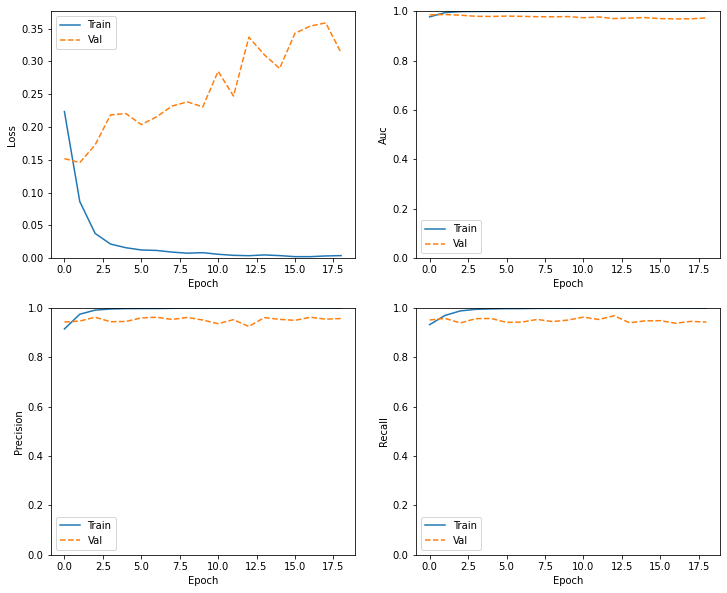

In [68]:
plot_metrics(history)

In [69]:
y_probas_train = model.predict(x_train)
y_probas_test = model.predict(x_test)

In [70]:
y_pred_test = np.round(y_probas_test) 

True Negatives:  3538
False Positives:  172
False Negatives:  190
True Positives:  3699


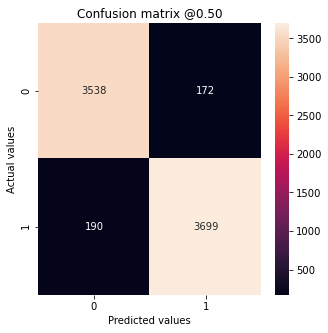

In [71]:
plot_cfm(y_test, y_pred_test)

In [72]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3710
           1       0.96      0.95      0.95      3889

    accuracy                           0.95      7599
   macro avg       0.95      0.95      0.95      7599
weighted avg       0.95      0.95      0.95      7599



In [73]:
f1 = f1_score(y_test, y_pred_test, average = 'weighted')
print('F1: %.2f' % f1)

F1: 0.95


In [74]:
auc = roc_auc_score(y_test, y_probas_test)
print('AUC: %.2f' % auc)

AUC: 0.99


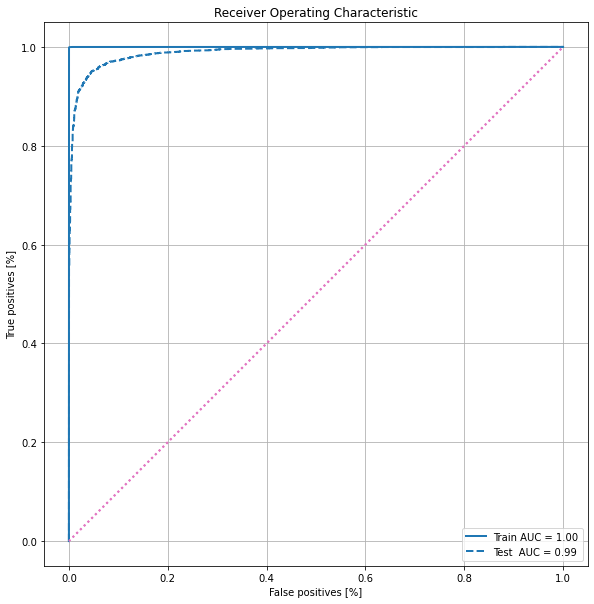

In [75]:
plot_roc("Train", y_train, y_probas_train, color = colors[0])
plot_roc("Test ", y_test, y_probas_test, color = colors[0], linestyle = '--')